In [15]:
from imports import *

In [16]:
df_train_tab = pd.read_csv('./processed-datasets/df_train_tab.csv')
df_val_tab = pd.read_csv('./processed-datasets/df_val_tab.csv')
df_test_tab = pd.read_csv('./processed-datasets/df_test_tab.csv')
x_train_ecg = pd.read_csv('./processed-datasets/x_train_ecg.csv')
x_val_ecg = pd.read_csv('./processed-datasets/x_val_ecg.csv')
x_test_ecg = pd.read_csv('./processed-datasets/x_test_ecg.csv')

In [3]:
x_train_tab = df_train_tab.drop(columns=['MRN_DEID', 'CardiacFuture_confirmed'])
x_val_tab = df_val_tab.drop(columns=['MRN_DEID', 'CardiacFuture_confirmed'])
x_test_tab = df_test_tab.drop(columns=['MRN_DEID', 'CardiacFuture_confirmed'])

y_train_tab = df_train_tab['CardiacFuture_confirmed'].values
y_val_tab = df_val_tab['CardiacFuture_confirmed'].values
y_test_tab = df_test_tab['CardiacFuture_confirmed'].values

In [4]:
# Dataset class for just ECG data
class ECGDataset(Dataset):
    def __init__(self, df_ecg, ecg, length): # ecg_data
        self.df_ecg = df_ecg
        self.ecg = ecg
        self.targets = self.df_ecg.CardiacFuture.values
        self.sig_length = length

        # Create an index list
        self.indices = list(range(len(df_ecg)))
    
    def __len__(self):
        return len(self.df_ecg)

    def __getitem__(self, index):
        actual_idx = self.indices[index]
        key = self.df_ecg.at[self.df_ecg.index[actual_idx], 'Image Name']
        # key = self.df_ecg.iloc[actual_idx]['Image Name']
        idx = list(self.ecg['Image Name'].values()).index(key)
        
        x = self.ecg['Lead1'][idx]
        if type(x) is list:
            x = np.array(x)
        x = x[~np.isnan(x)][:self.sig_length]
        x = normalizer.z_norm(x).reshape(1, -1)
        for j in [2,3,4,5,6]:
            sig = self.ecg['Lead'+str(j)][idx]
            if type(sig) is list:
                sig = np.array(sig)
            sig = sig[~np.isnan(sig)][:self.sig_length]
            sig = normalizer.z_norm(sig).reshape(1, -1)
            x = np.concatenate((x, sig), axis=0)
            
#         x = np.concatenate((self.ecg['Lead1'][idx].reshape(1, -1), self.ecg['Lead2'][idx].reshape(1, -1), 
#                self.ecg['Lead3'][idx].reshape(1, -1), self.ecg['Lead4'][idx].reshape(1, -1), 
#                self.ecg['Lead5'][idx].reshape(1, -1), self.ecg['Lead6'][idx].reshape(1, -1)), axis = 0)
#         x = np.nan_to_num(x)

        y = self.df_ecg.at[self.df_ecg.index[actual_idx], 'CardiacFuture_confirmed']
        
        x_ecg = torch.tensor(x, dtype=torch.float)
        y_ecg = torch.tensor(y, dtype=torch.float)
        return x_ecg, y_ecg

    def shuffle(self):
        # Shuffle the index list
        np.random.seed(seed)
        np.random.shuffle(self.indices)
    

In [5]:
# hyperparameters
length = 745
batch_size = 51

In [6]:
ecg = pkl.load(open('../ECG_data_NEW.pkl', 'rb'))

In [7]:
# Create the dataset and dataloader

train_dataset = ECGDataset(x_train_ecg, ecg, length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
sample = True
if sample:
    sampler = utils.ImbalancedDatasetSampler(train_dataset)
    train_loader = DataLoader(dataset=train_dataset, sampler=sampler, batch_size=batch_size)
else:
    train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)

val_dataset = ECGDataset(x_val_ecg, ecg, length)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [8]:
count_negatives = x_train_ecg['CardiacFuture_confirmed'].value_counts()[0]
count_positives = x_train_ecg['CardiacFuture_confirmed'].value_counts()[1]
class_counts = [count_negatives, count_positives]
total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]
class_weights

[1.0435025097601784, 23.987179487179485]

In [9]:
# Sample a few batches and print their dimensions
num_batches_to_check = 1

for i, (x_ecg, y_ecg) in enumerate(train_loader):
    if i >= num_batches_to_check:
        break
    print(f"Batch {i+1}:")
    print(f"ECG data shape: {x_ecg.shape}")
    print(f"ECG y shape: {y_ecg.shape}")
    print(y_ecg, type(y_ecg))
    print(x_ecg)
    print("------")


Batch 1:
ECG data shape: torch.Size([51, 6, 745])
ECG y shape: torch.Size([51])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]) <class 'torch.Tensor'>
tensor([[[0.4091, 0.4091, 0.4242,  ..., 0.5152, 0.5303, 0.5455],
         [0.4308, 0.4462, 0.4462,  ..., 0.5538, 0.5692, 0.5846],
         [0.5227, 0.5227, 0.5227,  ..., 0.5455, 0.5682, 0.5682],
         [0.3158, 0.3158, 0.3158,  ..., 0.6842, 0.7105, 0.7105],
         [0.8000, 0.8000, 0.8000,  ..., 0.5250, 0.5000, 0.4750],
         [0.3889, 0.4074, 0.4074,  ..., 0.4630, 0.4815, 0.5000]],

        [[0.5862, 0.5690, 0.5690,  ..., 0.3966, 0.5345, 0.5517],
         [0.4432, 0.4432, 0.4432,  ..., 0.3409, 0.3864, 0.3977],
         [0.5542, 0.5542, 0.5663,  ..., 0.4819, 0.5181, 0.5301],
         [0.6923, 0.6923, 0.6923,  ..., 0.5385, 0.7179, 0.7436],
         [0.3871

In [10]:
# class CNNBlock(nn.Module):
#     def __init__(self, dropout_prob_ecg=0.5):
#         super(CNNBlock, self).__init__()

#         # Convolutional Layers
#         self.conv1 = nn.Conv1d(in_channels=6, out_channels=32, kernel_size=50, padding=25)
#         self.bn1 = nn.BatchNorm1d(num_features=32)
#         self.pool = nn.MaxPool1d(kernel_size=50) #check
        
#         # Fully Connected Layers
#         self.flatten = nn.Flatten() # check
#         self.fc1 = nn.Linear(32*14, 128)
#         self.fc2 = nn.Linear(128, 32)

#         # Dropout
#         self.dropout = nn.Dropout(p=dropout_prob_ecg)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = F.relu(x)
#         x = self.dropout(x)
#         x = self.pool(x)
#         x = self.flatten(x)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
#         return x
    
# class MultiHeadSelfAttention(nn.Module):
#     def __init__(self, embed_dim, num_heads):
#         super(MultiHeadSelfAttention, self).__init__()
#         self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
        
#     def forward(self, x):
#         # Handle 2D inputs
#         if x.dim() == 2:
#             x = x.unsqueeze(1)
#         # MultiheadAttention expects input in the format (seq_len, batch_size, embed_dim)
#         x = x.permute(1, 0, 2) # check
#         attn_output, _ = self.multihead_attn(x, x, x)  # Explicitly provide x as query, key, and value
#         return attn_output.permute(1, 0, 2).squeeze(1)

# class ECGModel(nn.Module):
#     def __init__(self, num_heads):
#         super(ECGModel, self).__init__()
                
#         # 1D CNN and multihead self-attention for ECG data
#         self.cnn = CNNBlock()
#         self.ecg_attention = MultiHeadSelfAttention(embed_dim=32, num_heads=num_heads)  # Assuming 128 features after CNN
#         self.ecg_fc = nn.Linear(32, 32)

#         # Final FC layer(s)
#         # self.fc1 = nn.Linear(32 * 2, 32)  # Concatenated output
#         self.fc2 = nn.Linear(32, 1)
        
#     def forward(self, ecg_data):
#         ecg_data = self.cnn(ecg_data)
#         ecg_data = self.ecg_attention(ecg_data).squeeze(1)
#         ecg_data = self.ecg_fc(ecg_data)
#         output = self.fc2(ecg_data)

#         return output

In [11]:
class HeartNetModel(nn.Module):
    def __init__(self, in_channels):
        super(HeartNetModel, self).__init__()
        # Convolutional block
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=7, stride=1, padding='same')
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding='same')
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding='same')
        self.bn3 = nn.BatchNorm1d(256)
        self.softmax3 = nn.Softmax(dim=1)
        self.dropout3 = nn.Dropout(0.5)

        self.conv4 = nn.Conv1d(256, 128, kernel_size=1, stride=1, padding='same')

        # Since the model specifies multi-head attention and a global average pooling,
        # we need to flatten the output from conv layers before applying these.
        # self.flatten = nn.Flatten()

        # Multi-Head Attention Block
        # PyTorch doesn't have a direct multi-head attention for 1d convolutions.
        # A workaround is to use the nn.MultiheadAttention which works on sequences.
        # We would need to adjust dimensions appropriately.
        self.multihead_attn = nn.MultiheadAttention(embed_dim=128, num_heads=4, dropout=0.3)

        # Output Block
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        # Convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.softmax3(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = x.permute(2, 0, 1)  # Adjust dimensions for multihead attention (L, N, E)
        attn_output, _ = self.multihead_attn(x, x, x)
        x = attn_output.permute(1, 2, 0)  # Back to (N, E, L)

        # Global average pooling and classifier
        x = self.global_avg_pooling(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)
        return x

# Assuming the input data dimensions are [batch_size, no_of_leads, length]
# For 6-lead ECG, the number of in_channels will be 6
# For binary classification, the number of classes will be 2

# Create the model instance
heartnet_model = HeartNetModel(in_channels=6)



In [16]:
# Training
# Hyperparameters
num_epochs = 20
learning_rate = 1e-5
num_heads = 2  # The number of heads in the multi-head attention block

# Use GPU if available
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# Model, Loss, Optimizer
model = HeartNetModel(in_channels=6)
# Assuming class_weights is a list or array with the class weights
pos_weight = torch.tensor([class_weights[1]]).to(device)
n = 5
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight//n)
optimizer = SGD(model.parameters(), lr=learning_rate)

# Scheduler for cyclic learning rate
scheduler = CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=2000, mode="triangular2", cycle_momentum=False)

model = model.to(device)

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Lists to store true labels and model predictions for AUROC computation
all_labels = []
all_predictions = []

# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, (ecg_data, ecg_labels) in enumerate(train_loader):
        ecg_data, ecg_labels = ecg_data.to(device), ecg_labels.to(device)
        
        # Forward pass
        outputs = model(ecg_data).squeeze()
        loss = criterion(outputs, ecg_labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss_for_epoch = running_loss / len(train_loader)
    train_losses.append(train_loss_for_epoch)
    # print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss_for_epoch:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation loop
    model.eval()
    val_running_loss = 0.0
    epoch_labels = []
    epoch_predictions = []
    with torch.no_grad():
        for ecg_data, ecg_labels in val_loader:
            ecg_data, ecg_labels = ecg_data.to(device), ecg_labels.to(device)
            
            outputs = model(ecg_data).squeeze()
            loss = criterion(outputs, ecg_labels)
            val_running_loss += loss.item()

            epoch_labels.extend(ecg_labels.cpu().numpy())
            epoch_predictions.extend(outputs.squeeze().cpu().numpy())

    val_loss_for_epoch = val_running_loss / len(val_loader)
    val_losses.append(val_loss_for_epoch)
    # print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss_for_epoch:.4f}")
    print(f"Validation Loss: {val_running_loss/len(val_loader):.4f}")

# Note: You should calculate the class weights based on your dataset's distribution
# and replace `train_dataset` and `val_dataset` with your actual datasets.
    # Append the labels and predictions for this epoch for AUROC computation
    all_labels.extend(epoch_labels)
    all_predictions.extend(epoch_predictions)


Epoch [1/20], Loss: 1.0122
Validation Loss: 0.8136
Epoch [2/20], Loss: 0.9817
Validation Loss: 0.8120
Epoch [3/20], Loss: 1.0021
Validation Loss: 0.8142
Epoch [4/20], Loss: 1.0093
Validation Loss: 0.8126
Epoch [5/20], Loss: 0.9827
Validation Loss: 0.8111
Epoch [6/20], Loss: 1.0159
Validation Loss: 0.8133
Epoch [7/20], Loss: 0.9930
Validation Loss: 0.8125
Epoch [8/20], Loss: 0.9631
Validation Loss: 0.8140
Epoch [9/20], Loss: 0.9853
Validation Loss: 0.8117
Epoch [10/20], Loss: 1.0167
Validation Loss: 0.8139
Epoch [11/20], Loss: 1.0029
Validation Loss: 0.8124
Epoch [12/20], Loss: 0.9862
Validation Loss: 0.8116
Epoch [13/20], Loss: 0.9989
Validation Loss: 0.8138
Epoch [14/20], Loss: 1.0039
Validation Loss: 0.8122
Epoch [15/20], Loss: 0.9993
Validation Loss: 0.8107
Epoch [16/20], Loss: 1.0030
Validation Loss: 0.8107
Epoch [17/20], Loss: 0.9948
Validation Loss: 0.8121
Epoch [18/20], Loss: 1.0026
Validation Loss: 0.8106
Epoch [19/20], Loss: 0.9942
Validation Loss: 0.8120
Epoch [20/20], Loss: 

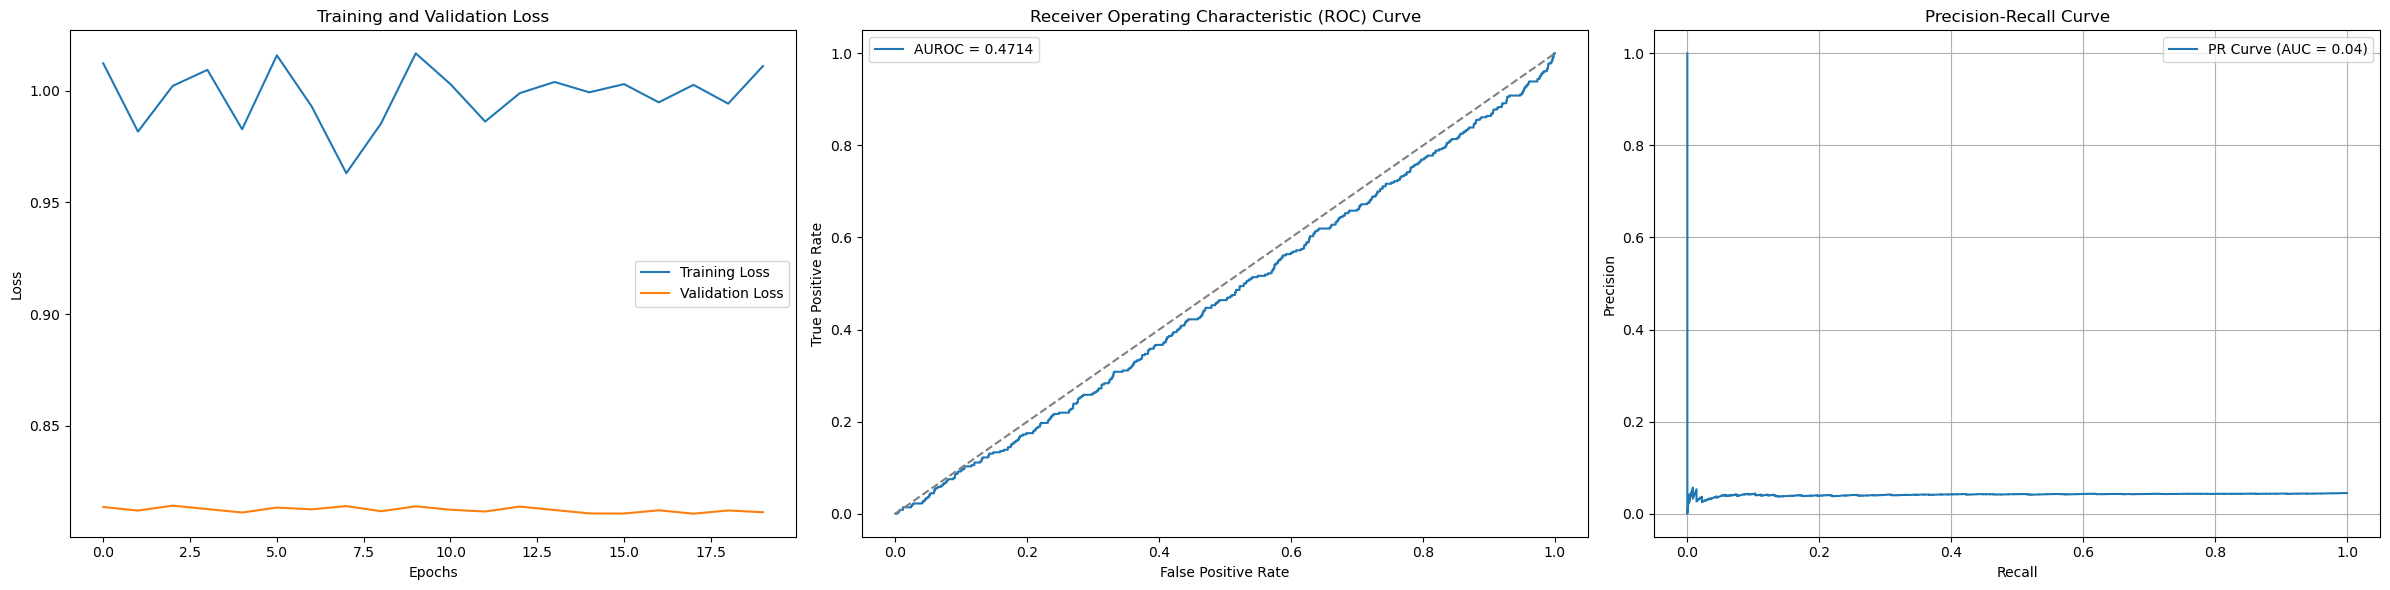

In [17]:
# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(all_labels, all_predictions)
   
# Compute AUC-PR
auc_pr = auc(recall, precision)

fig, ax = plt.subplots(1, 3, figsize=(24,6))  # 1 row, 3 columns

# Plotting Training and Validation Loss
ax[0].plot(train_losses, label='Training Loss')
ax[0].plot(val_losses, label='Validation Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Compute and Plot AUROC on the Validation Set
auroc_val = roc_auc_score(all_labels, all_predictions)
fpr, tpr, _ = roc_curve(all_labels, all_predictions)
ax[1].plot(fpr, tpr, label=f'AUROC = {auroc_val:.4f}')
ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[1].legend()

# Plot the PR curve
ax[2].plot(recall, precision, label=f'PR Curve (AUC = {auc_pr:.2f})')
ax[2].set_xlabel('Recall')
ax[2].set_ylabel('Precision')
ax[2].set_title('Precision-Recall Curve')
ax[2].legend()
ax[2].grid(True)

# Display the plots
plt.tight_layout()  # adjust the spacing between plots
plt.show()

In [14]:
# # Hyperparameters
# num_epochs = 20
# learning_rate = 1e-7
# num_heads = 2

# # Use GPU if available
# device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# # Model, Loss, Optimizer
# model = ECGModel(num_heads)
# pos_weight = torch.tensor([class_weights[1]]).to(device)
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# # criterion = nn.BCELoss() # binary cross-entropy loss
# optimizer = SGD(model.parameters(), lr=learning_rate)

# # Scheduler for cyclic learning rate
# scheduler = CyclicLR(optimizer, base_lr=1e-7, max_lr=1e-4, step_size_up=2000, mode="triangular2", cycle_momentum=False)

# model = model.to(device)

# # Lists to store training and validation losses
# train_losses = []
# val_losses = []

# # Lists to store true labels and model predictions for AUROC computation
# all_labels = []
# all_predictions = []

# # Training Loop
# for epoch in range(num_epochs):
#     train_dataset.shuffle()
#     model.train()
#     running_loss = 0.0
    
#     for i, (ecg_data, ecg_labels) in enumerate(train_loader):
#         scheduler.step()
#         ecg_data, ecg_labels = ecg_data.to(device), ecg_labels.to(device)
        
#         # Forward pass
#         outputs = model(ecg_data).squeeze()
#         loss = criterion(outputs, ecg_labels) # comparing with ecg_labels
        
#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     train_loss_for_epoch = running_loss/len(train_loader)
#     train_losses.append(train_loss_for_epoch)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    
#     # Validation Loop to check performance on validation set
#     model.eval()
#     val_running_loss = 0.0
#     epoch_labels = []
#     epoch_predictions = []
#     with torch.no_grad():
#         for ecg_data, ecg_labels in val_loader:
#             ecg_data, ecg_labels = ecg_data.to(device), ecg_labels.to(device)
            
#             outputs = model(ecg_data).squeeze()
#             loss = criterion(outputs, ecg_labels)
#             val_running_loss += loss.item()

#             epoch_labels.extend(ecg_labels.cpu().numpy())
#             epoch_predictions.extend(outputs.squeeze().cpu().numpy())

#     val_loss_for_epoch = val_running_loss/len(val_loader)
#     val_losses.append(val_loss_for_epoch)
#     print(f"Validation Loss: {val_running_loss/len(val_loader):.4f}")

#     # Append the labels and predictions for this epoch for AUROC computation
#     all_labels.extend(epoch_labels)
#     all_predictions.extend(epoch_predictions)


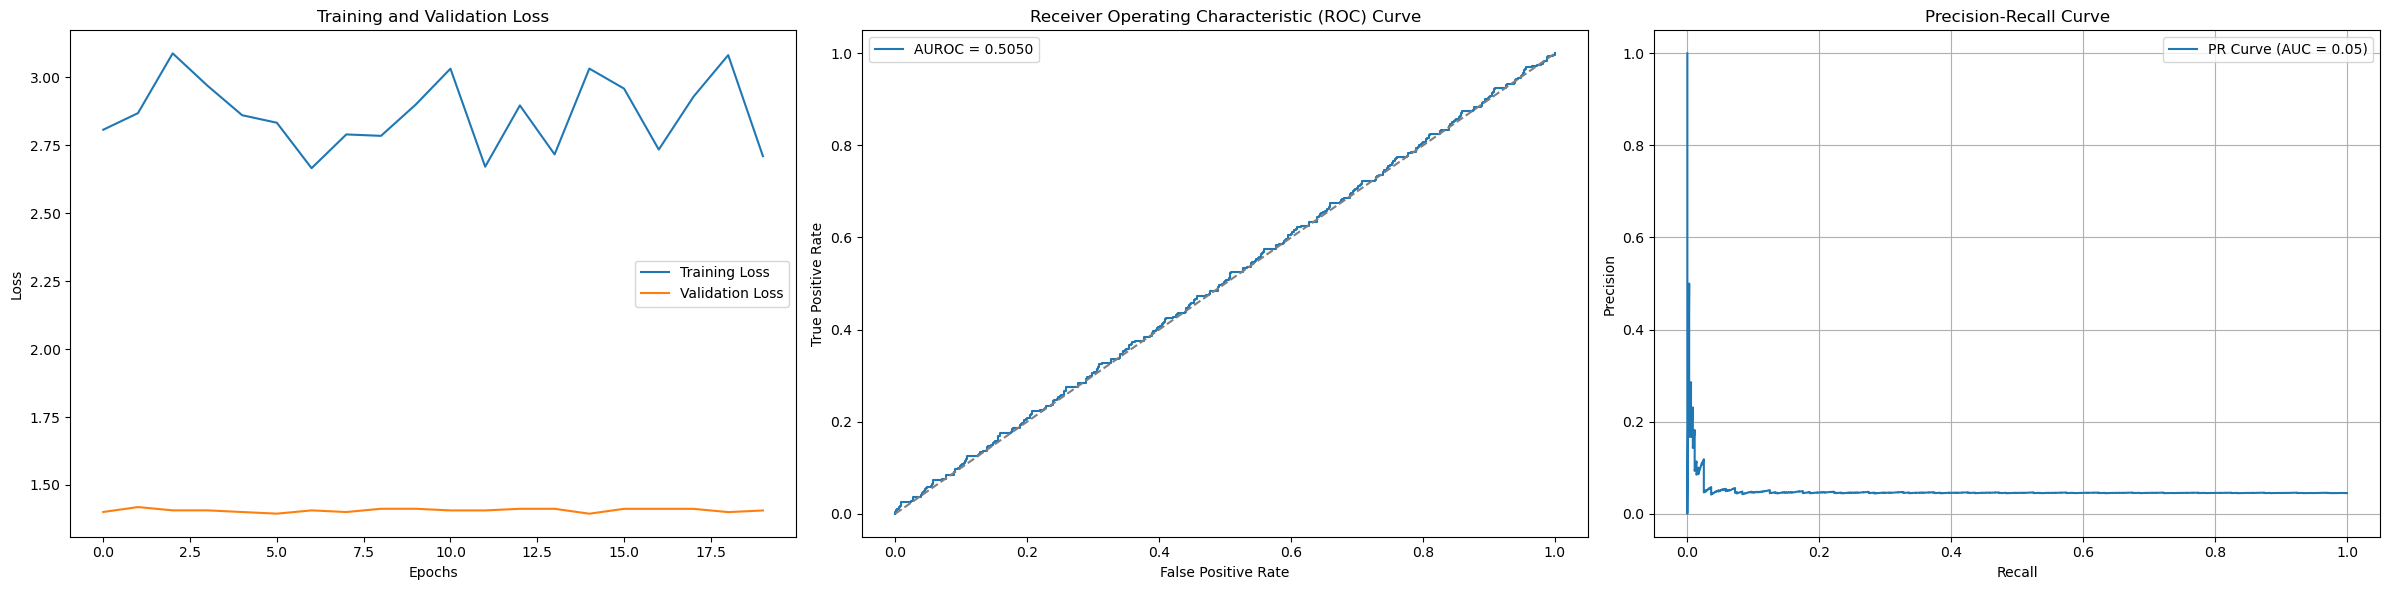

In [15]:
# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(all_labels, all_predictions)
   
# Compute AUC-PR
auc_pr = auc(recall, precision)

fig, ax = plt.subplots(1, 3, figsize=(24,6))  # 1 row, 3 columns

# Plotting Training and Validation Loss
ax[0].plot(train_losses, label='Training Loss')
ax[0].plot(val_losses, label='Validation Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Compute and Plot AUROC on the Validation Set
auroc_val = roc_auc_score(all_labels, all_predictions)
fpr, tpr, _ = roc_curve(all_labels, all_predictions)
ax[1].plot(fpr, tpr, label=f'AUROC = {auroc_val:.4f}')
ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[1].legend()

# Plot the PR curve
ax[2].plot(recall, precision, label=f'PR Curve (AUC = {auc_pr:.2f})')
ax[2].set_xlabel('Recall')
ax[2].set_ylabel('Precision')
ax[2].set_title('Precision-Recall Curve')
ax[2].legend()
ax[2].grid(True)

# Display the plots
plt.tight_layout()  # adjust the spacing between plots
plt.show()